In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# Reflect the existing database into a new model
Base = automap_base()

# Use only the autoload_with parameter to prepare the Base
Base.prepare(autoload_with=engine)

# Print out the classes found to verify the table names
print(Base.classes.keys())

['station', 'measurement']


In [8]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


Date one year ago: 2016-08-23 00:00:00
            date  precipitation
0     2016-08-24           0.08
1006  2016-08-24            NaN
1524  2016-08-24           2.15
702   2016-08-24           2.28
360   2016-08-24           2.15


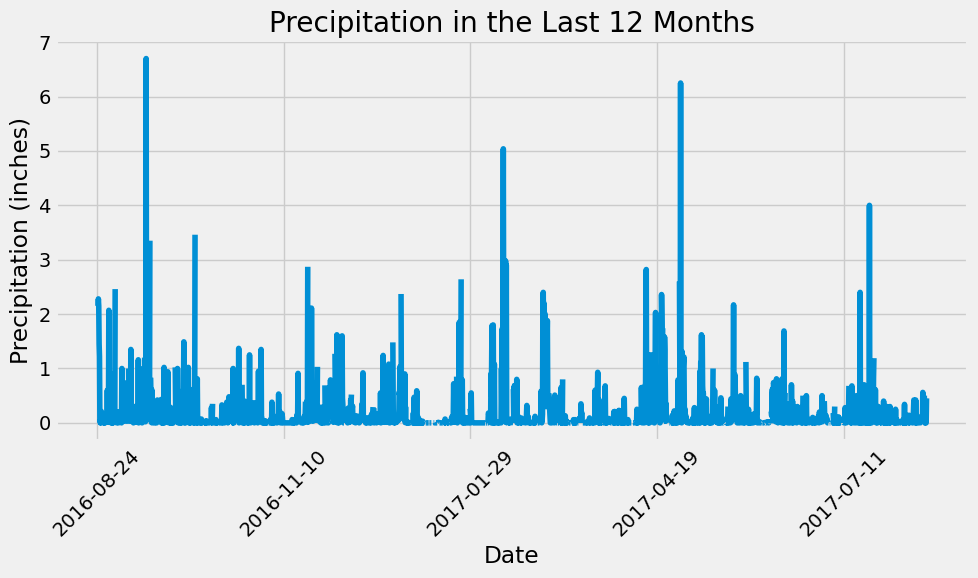

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in the dataset
one_year_ago = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)
print(f"Date one year ago: {one_year_ago}")

# Perform a query to retrieve the date and precipitation scores for the last year
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= one_year_ago
).all()

# Save the query results as a Pandas DataFrame with explicit column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["date", "precipitation"])

# Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values("date")
print(precipitation_df.head())  # Display the first few rows for verification

# Use Pandas plotting with Matplotlib to plot the data
precipitation_df.set_index("date", inplace=True)
precipitation_df.plot(figsize=(10, 6), title="Precipitation in the Last 12 Months", legend=False)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics and format them into a proper DataFrame
summary_stats = precipitation_df["precipitation"].describe()

# Create a DataFrame with explicit labels
summary_df = pd.DataFrame({
    "Metric": ["Count", "Mean", "Std Dev", "Min", "25%", "50%", "75%", "Max"],
    "Value": summary_stats.values
})

# Display the nicely formatted DataFrame
summary_df


,Metric,Value
0,Count,2015.000000
1,Mean,0.176462
2,Std Dev,0.460288
3,Min,0.000000
4,25%,0.000000
5,50%,0.020000
6,75%,0.130000
7,Max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Query to find the most active stations
active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

# Display the results
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [19]:
# Get the most active station ID from the previous query
most_active_station = active_stations[0][0]  # The first station in the list

# Query to calculate the lowest, highest, and average temperature
temperature_stats = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    )
    .filter(Measurement.station == most_active_station)
    .all()
)

# Display the results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(f"Most Active Station: {most_active_station}")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp}")

Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


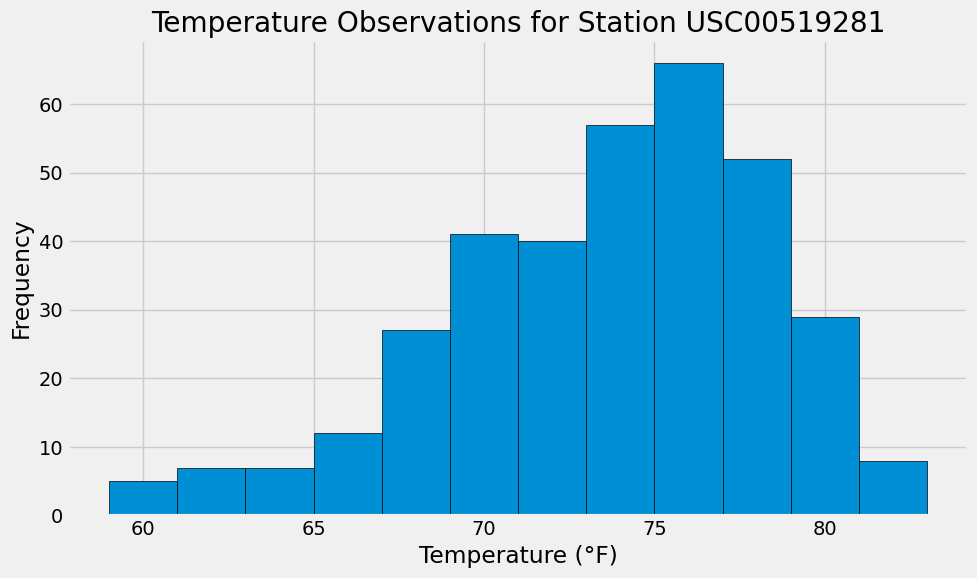

In [21]:
# Query the last 12 months of temperature observation data for the most active station
temperature_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

# Convert the query results into a list of temperatures
temperature_list = [temp[0] for temp in temperature_data]

# Plot the data as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_list, bins=12, edgecolor="black")
plt.title(f"Temperature Observations for Station {most_active_station}")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close Session

In [22]:
# Close Session
session.close()